# **Topic Modelling**
The aim of this notebook is to analyze the complaints sent by the customers and understand what are the main topics that come out. The results of this analysis will be then used to link the two dataframes together. In particular, we are interested in understanding whether the variables that drive clients to churn the most are the same that come out as main topics in the complaints. <br>

Topic modelling is an unsupervised learning method that is used to identify the abstract topics that occur in a collection of documents. **Latent Dirichlet Allocation** (LDA) is a popular topic modelling method which exploits probabilistic assumptions on the documents.

## **Imports and Useful Functions**

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import warnings

import re
import nltk
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

import os

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

## **Text Processing**

In [2]:
clients = pd.read_excel('btUTgX.xlsx', index_col=0)
complaints = pd.read_excel('EaUgXb.xlsx', index_col = 0)

In [3]:
complaints.head()

,complaint,complaint_number
customerID,,
9565-DJPIB,The streaming TV service frequently buffers or...,1
4342-HFXWS,The DSL internet service has been inconsistent...,1
4342-HFXWS,The streaming TV service often buffers excessi...,2
4342-HFXWS,"Despite having tech support included, it takes...",3
4342-HFXWS,The device protection plan I pay for did not c...,4


At the moment, we are not interested in the complaint number, therefore we drop the corresponding column.

In [4]:
data = complaints.drop(columns=['complaint_number'])

In order to perform topic modelling, we first need to clean the data. In particular, we remove punctuation, convert to lowercase and remove stopwords from the complaints.

In [ ]:
data['text_processed'] = data['complaint'].map(lambda x: re.sub('[,\.!?]', '', x))  # remove punctuation
data['text_processed'] = data['text_processed'].map(lambda x: x.lower())  # lowercase
data['text_processed'] = data['text_processed'].map(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])  # remove stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatricecitterio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
data['text_processed'].head()

customerID
9565-DJPIB    streaming tv service frequently buffers crashe...
4342-HFXWS    dsl internet service inconsistent lately frequ...
4342-HFXWS    streaming tv service often buffers excessively...
4342-HFXWS    despite tech support included takes long time ...
4342-HFXWS    device protection plan pay cover recent issue ...
Name: text_processed, dtype: object

Now we plot the complaints using the wordcloud library to understand which words occur the most.

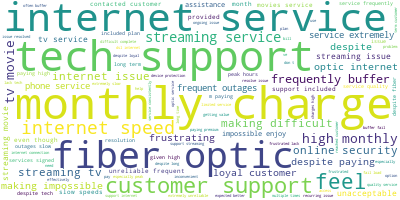

In [ ]:
string = ','.join(list(data['text_processed'].values))

wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(string)
wordcloud.to_image()

The word size in the plot above represents the frequency of the word in the corpus. Therefore, from this, we can already see how most of the complains are about:
1. monthly charges
2. tech support
3. internet service
4. fiber optic

Thus this plot, despite being extremely simple, already gives us an interesting insights on what are the issues that the customers complain about the most: lack of support, high charges, problems with internet service and fiber optic.

Now we start transforming the data. First we tokenize the text and then convert the tokenized object into a corpus and a dictionary that will serbe as input for training the LDA model.

In [ ]:
data = data.text_processed.values.tolist()
data_words = list(sent_to_words(data))

data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['streaming', 'tv', 'service', 'frequently', 'buffers', 'crashes', 'making', 'impossible', 'watch', 'anything', 'without', 'interruptions', 'ongoing', 'despite', 'high', 'monthly', 'charges', 'frustrated', 'lack', 'reliability']


In [15]:
id2word = corpora.Dictionary(data_words)
texts = data_words

corpus = [id2word.doc2bow(text) for text in texts]

## **LDA Model**

After different trials, we set the number of topics to 5 as we see empirically that this gives the best results. Of course, this can be easily modified. The rest of the parameters is set to default.

In [18]:
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"support" + 0.027*"customer" + 0.022*"services" + 0.021*"streaming" + '
  '0.020*"issues" + 0.020*"like" + 0.019*"internet" + 0.017*"high" + '
  '0.015*"despite" + 0.015*"service"'),
 (1,
  '0.034*"support" + 0.032*"service" + 0.027*"internet" + 0.020*"customer" + '
  '0.019*"tech" + 0.017*"issue" + 0.017*"despite" + 0.013*"issues" + '
  '0.011*"phone" + 0.010*"lack"'),
 (2,
  '0.030*"service" + 0.029*"streaming" + 0.028*"internet" + 0.018*"despite" + '
  '0.017*"support" + 0.017*"services" + 0.017*"tv" + 0.015*"making" + '
  '0.014*"issue" + 0.013*"movies"'),
 (3,
  '0.048*"service" + 0.032*"internet" + 0.020*"streaming" + 0.019*"despite" + '
  '0.019*"monthly" + 0.019*"paying" + 0.017*"high" + 0.017*"charges" + '
  '0.016*"services" + 0.015*"like"'),
 (4,
  '0.029*"support" + 0.029*"internet" + 0.017*"customer" + 0.017*"issues" + '
  '0.017*"assistance" + 0.016*"despite" + 0.016*"tech" + 0.013*"services" + '
  '0.013*"payment" + 0.012*"paying"')]


We have built a model with 5 topics where each topic is a combination of keywords, and each keyword contributes a certain weight to the topic.

## **Visualization** 
Let’s visualize the topics for interpretability. To do so, we use pyLDAvis package, which allows interactive visualization. The plot will allow us to:
1) manually select each topic to view most frequent and/or relevant terms
2) understand how topics relate to each other

In [21]:
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.051446 -0.005170       1        1  37.499764
2      0.054245 -0.008852       2        1  20.616665
1     -0.045418 -0.057271       3        1  17.955065
0      0.010099  0.039294       4        1  13.347497
4     -0.070372  0.031999       5        1  10.581009, topic_info=          Term        Freq       Total Category  logprob  loglift
47     support  538.000000  538.000000  Default  30.0000  30.0000
72    customer  394.000000  394.000000  Default  29.0000  29.0000
41  assistance  159.000000  159.000000  Default  28.0000  28.0000
49        tech  248.000000  248.000000  Default  27.0000  27.0000
86      issues  308.000000  308.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
15     service   28.759868  802.520910   Topic5  -4.4964  -1.0827
50        time   16.804959  102.760180   Topic5  -5.0337   0.4354
6   frustrated   16.156629   99.594408   Topic5  -5.0731   0.4273
7         high   20.366715  293.428237   Topic5  -4.8415  -0.4216
2      charges   17.043516  261.906358   Topic5  -5.0196  -0.4861

[411 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
191       2  0.486727  absence
317       1  0.071839  account
317       2  0.107759  account
317       3  0.610633  account
317       4  0.035920  account
...     ...       ...      ...
288       1  0.393651    would
288       2  0.062626    would
288       3  0.125252    would
288       4  0.143146    would
288       5  0.277345    would

[864 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1, 5])

We thought of removing the most frequent words to differentiate more between topics. However, this makes the analysis impossible to interpret as the only words that remain are adjectives.